<h3>Charlie AutoEncoder</h3>

In [87]:
# @title
# Generate random symbols as input
def generate_symbols(input_length, M):
    return torch.randint(0, M, (input_length,))  # generate (batch_size) random symbols between 0 and M - 1

# Create sliding windows from input data
def create_windows(data, window_size, step_size):
    num_windows = (len(data) - window_size) // step_size + 1
    windows = torch.stack([
        data[i:i + window_size]  # Extract rows for each window
        for i in range(0, num_windows * step_size, step_size)
    ])

    return windows

def plot_two_lines(x1, y1, x2, y2, title, x_label, y_label, label1="Line 1", label2="Line 2"):
    """
    Creates an interactive Plotly plot for two solid lines over the same x-axis.

    Parameters:
    - x1, y1: Data for the first line
    - x2, y2: Data for the second line
    - title: Plot title
    - x_label: Label for the x-axis
    - y_label: Label for the y-axis
    - label1: Legend name for the first line (default: "Line 1")
    - label2: Legend name for the second line (default: "Line 2")
    """

    # Create an interactive figure
    fig = go.Figure()

    # Add first line trace (solid blue)
    fig.add_trace(go.Scatter(
        x=x1, y=y1,
        mode='lines', name=label1,
        line=dict(color='blue', width=2)  # Solid line, blue color
    ))

    # Add second line trace (solid red)
    fig.add_trace(go.Scatter(
        x=x2, y=y2,
        mode='lines', name=label2,
        line=dict(color='red', width=2)  # Solid line, red color
    ))

    # Configure layout for better visibility
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="plotly_white",
        hovermode="x",  # Enables hover tool on x-axis
    )

    # Show the interactive plot
    fig.show()

def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label="Training Loss", color="blue", alpha=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# REMEMBER TO IMPORT: model_weights_windowed.pth, best_params_windowed.json

# MODIFIED TRAINING (INTEGRATION)

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

def loader(weights_filepath, params_filepath):
    weights = torch.load(weights_filepath, weights_only=True, map_location=torch.device('cpu'))
    with open(params_filepath, "r") as f:
        params = json.load(f)
    return weights, params

# Load model weights and parameters
weights, params = loader(
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\model_weights.pth",
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\best_params.json"
)

# Hyperparameters
M = 256
n = 2
window_size = 512
epochs = 100
learning_rate = 1e-4

# Define Transmitter
class Transmitter(nn.Module):
    def __init__(self, M, n):
        super(Transmitter, self).__init__()
        self.fc1 = nn.Linear(M, 8 * M)
        self.fc2 = nn.Linear(8 * M, 8 * M) # try wider model deeper
        self.fc3 = nn.Linear(8 * M, n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Channel
# Define the wider model
class FiberOpticFNN0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN0, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout for regularization
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class IdentityChannel(nn.Module):
    def forward(self, x):
        return x

# Define Receiver
class Receiver(nn.Module):
    def __init__(self, n, M):
        super(Receiver, self).__init__()
        self.fc1 = nn.Linear(n, 8 * M)
        self.fc2 = nn.Linear(8 * M, 8 * M)  # try wider model -> deeper
        self.fc3 = nn.Linear(8 * M, M)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

transmitter = Transmitter(M, n)

channel = FiberOpticFNN0(2 * window_size, params["hidden_dim"], n, params["dropout"])
channel.load_state_dict(weights["model weights"], strict=False)
# channel = IdentityChannel();

receiver = Receiver(n, M)

for param in transmitter.parameters():
    assert param.requires_grad
for param in channel.parameters():
    param.requires_grad = False
for param in receiver.parameters():
    assert param.requires_grad

# Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(transmitter.parameters()) + list(receiver.parameters()), lr=learning_rate)

# Training loop with batching
transmitter.train()
channel.eval()
receiver.train()
training_losses = []

for epoch in range(epochs):
  symbols = torch.randint(0, M, (window_size,))
  target_symbol = symbols[window_size // 2]
  symbols_one_hot = F.one_hot(symbols, num_classes=M).float()

  transmitted = transmitter(symbols_one_hot)

  transmitted_flat = transmitted.view(1, -1)
  received = channel(transmitted_flat)

  decoded = receiver(received)

  optimizer.zero_grad()
  loss = criterion(decoded, target_symbol.unsqueeze(0))
  loss.backward()
  optimizer.step()

  print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")
  training_losses.append(loss.item())

Epoch [1/100] - Loss: 5.4809
Epoch [2/100] - Loss: 5.5839
Epoch [3/100] - Loss: 5.5433
Epoch [4/100] - Loss: 5.5124
Epoch [5/100] - Loss: 5.4989
Epoch [6/100] - Loss: 5.5554
Epoch [7/100] - Loss: 5.5063
Epoch [8/100] - Loss: 5.6948
Epoch [9/100] - Loss: 5.5529
Epoch [10/100] - Loss: 5.5263
Epoch [11/100] - Loss: 5.6062
Epoch [12/100] - Loss: 4.8407
Epoch [13/100] - Loss: 5.5210
Epoch [14/100] - Loss: 5.5216
Epoch [15/100] - Loss: 5.6231
Epoch [16/100] - Loss: 5.6962
Epoch [17/100] - Loss: 5.6439
Epoch [18/100] - Loss: 5.6668
Epoch [19/100] - Loss: 5.4898
Epoch [20/100] - Loss: 5.4459
Epoch [21/100] - Loss: 5.5525
Epoch [22/100] - Loss: 5.6656
Epoch [23/100] - Loss: 5.6467
Epoch [24/100] - Loss: 5.5672
Epoch [25/100] - Loss: 5.6849
Epoch [26/100] - Loss: 5.7101
Epoch [27/100] - Loss: 5.6005
Epoch [28/100] - Loss: 5.4906
Epoch [29/100] - Loss: 5.8069
Epoch [30/100] - Loss: 5.5083
Epoch [31/100] - Loss: 5.5452
Epoch [32/100] - Loss: 5.6660
Epoch [33/100] - Loss: 5.5602
Epoch [34/100] - Lo

<h3>AutoEncoder Attempt #2 - no sliding window</h3>

In [135]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

class TransmitterRecieverModel(nn.Module):
    def __init__(self, input_size,hidden_size,channel_size,channel_func,weight_init=1):
        super().__init__()
        self.transmitter_fc1 = nn.Linear(input_size, hidden_size)
        self.transmitter_fc2 = nn.Linear(hidden_size, channel_size)

        self.reciever_fc1 = nn.Linear(channel_size, hidden_size)
        self.reciever_fc2 = nn.Linear(hidden_size, input_size)

        self.channel_function = channel_func

        init.uniform_(self.transmitter_fc1.weight,a=-weight_init,b=weight_init)
        init.uniform_(self.transmitter_fc2.weight, a=-weight_init,b=weight_init)
        init.uniform_(self.reciever_fc1.weight, a=-weight_init,b=weight_init)
        init.uniform_(self.reciever_fc2.weight,a=-weight_init,b=weight_init)

    def forward(self, x):
        transmitter_output = F.sigmoid(self.transmitter_fc1(x))
        transmitter_output = self.transmitter_fc2(transmitter_output)

        channel_output = self.channel_function(transmitter_output)

        reciever_output = F.sigmoid(self.reciever_fc1(channel_output))
        reciever_output = self.reciever_fc2(reciever_output)

        return reciever_output
    
    def evaluate(self, x):
        with torch.no_grad():
            output = F.softmax(self.forward(x),dim=-1)
            output = [torch.argmax(o).item() for o in output]
            return output


    def train_model(self,x,y,epochs=10,learning_rate=0.001):
        training_loss = []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(),lr=learning_rate)
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            #print(f"Epoch {epoch} Loss: {loss.item()}")
        return training_loss

C:\Users\tomha\AppData\Local\Temp\ipykernel_16608\841660291.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model.evaluate(torch.tensor(input_data_one_hot,dtype=torch.float32))


Input Data: 
tensor([220, 152,  30,  90,  89,  56, 104, 184, 252,  28,  59,  70, 180, 153,
        115, 179, 231, 178, 251, 144, 103,  74,  34,  81, 115,  20, 144, 205,
         22, 208,  67, 111,  46, 167,  39, 150, 165, 239,  75, 112,  22, 246,
        162,  35, 196, 130, 205, 158,  70, 220, 216,  77,  91, 198,  39, 250,
        133,  91, 130, 248,  72,  70, 217,  38, 247, 163, 137, 223,  66, 205,
        246, 238, 109,  94, 134,  51, 144,   2, 213, 194,  39,  52,  83,  99,
         29, 111,  94, 129,   9, 120,  41, 109, 123, 110,  44,  27, 172, 152,
        231, 159,  50, 133, 168,  61, 252, 167, 251,  41, 129,  75, 200, 248,
        113,  35,  75,  37, 246, 101,  69, 151, 226, 122, 178,  83, 183,   8,
        138,  50,  34, 133,  40, 194, 191, 190,  42,  82,  14, 113,  43,   5,
        235,  24, 239, 242, 248, 108,  79, 231, 234, 101, 246,  48,  35, 120,
         78, 125, 164,  48, 222, 190, 104, 154, 173,  10,  22, 168,  60,  62,
        216, 118, 164,  72, 168, 190,   1, 237, 188

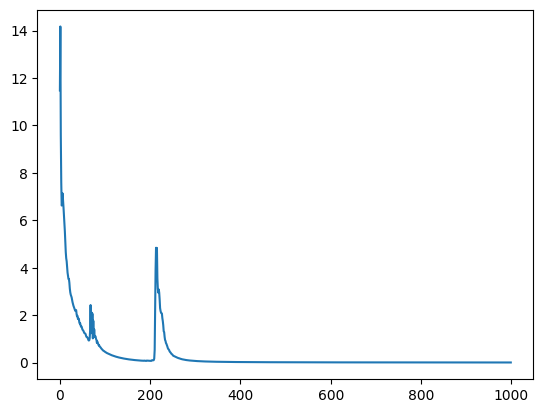

In [137]:
# identity matrix --> transmitter --> identity channel --> reciever --> identity matrix
import numpy as np
import torch
import matplotlib.pyplot as plt

input_size = 256
hidden_size = 128
channel_size = 2
channel_func = lambda x: x

model = TransmitterRecieverModel(input_size,hidden_size,channel_size,channel_func)

input_data = torch.randint(0, input_size, (input_size,), dtype=torch.long)

input_data_one_hot = torch.tensor(np.eye(input_size)[input_data],dtype=torch.float32)

training_loss = model.train_model(input_data_one_hot,input_data, learning_rate=0.1,epochs=1000)

output = model.evaluate(torch.tensor(input_data_one_hot,dtype=torch.float32))
print("Input Data: ")
print(input_data)
print("Output Data: ")
print(output)

plt.figure()
plt.plot(training_loss)
plt.show()

<h3>AutoEncoder Attempt #2 - With sliding window & Fiber Channel</h3>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------------------------------------------------------
def loader(weights_filepath, params_filepath):
    weights = torch.load(weights_filepath, weights_only=True, map_location=torch.device('cpu'))
    with open(params_filepath, "r") as f:
        params = json.load(f)
    return weights, params

# Load model weights and parameters
weights, params = loader(
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\model_weights.pth",
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\best_params.json"
)


In [12]:
# Modified Autoencoder that groups input into windows BEFORE encoding.
class AutoEncoderV2(nn.Module):
    def __init__(self, input_size, hidden_size, channel_size, channel_func, window_length):
        """
        Args:
            input_size (int): Dimensionality of one-hot vectors (alphabet size).
            hidden_size (int): Hidden layer dimension.
            channel_size (int): Dimension of the transmitter output (e.g., 2 for I/Q).
            channel_func (callable): The fiber channel function. It expects an input of size (2 * window_length).
            window_length (int): Number of symbols per window.
        """
        super().__init__()
        self.input_size = input_size      # e.g., 4096 (alphabet size)
        self.window_length = window_length  # e.g., 1024
        self.channel_size = channel_size    # e.g., 2 (I/Q)

        # Transmitter: processes one symbol at a time.
        self.transmitter_fc1 = nn.Linear(input_size, hidden_size)
        self.transmitter_fc2 = nn.Linear(hidden_size, channel_size)

        self.channel_function = channel_func
        
        # Receiver: decodes the channel output back to logits over the alphabet.
        self.reciever_fc1 = nn.Linear(channel_size, hidden_size)
        self.reciever_fc2 = nn.Linear(hidden_size, input_size)

     

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (total_length, input_size), where total_length is divisible by window_length.
        Returns:
            A tensor of shape (num_windows, input_size), where each row corresponds to the receiver's
            output for that window.
        """
        # Group input into non-overlapping windows of size window_length.
        num_windows = x.shape[0] // self.window_length
        # New shape: (num_windows, window_length, input_size)
        x_windows = x.view(num_windows, self.window_length, self.input_size)
        
        # Process each symbol in each window through the transmitter.
        x_flat = x_windows.view(-1, self.input_size)  # Shape: (num_windows * window_length, input_size)
        tx_hidden = torch.sigmoid(self.transmitter_fc1(x_flat))
        tx_symbols = self.transmitter_fc2(tx_hidden)     # Shape: (num_windows * window_length, channel_size)
        
        # Reshape back into windows: (num_windows, window_length, channel_size)
        tx_windows = tx_symbols.view(num_windows, self.window_length, self.channel_size)
        
        # Flatten each window to create a vector of size (window_length * channel_size).
        # With window_length=1024 and channel_size=2, this gives a vector of size 2048.
        tx_windows_flat = tx_windows.view(num_windows, -1)
        
        # Pass each flattened window through the fiber channel.
        channel_out = self.channel_function(tx_windows_flat)  # Expected shape: (num_windows, channel_size)
        
        # Decode the channel output using the receiver.
        rx_hidden = torch.sigmoid(self.reciever_fc1(channel_out))
        rx_output = self.reciever_fc2(rx_hidden)  # Shape: (num_windows, input_size)
        return rx_output

    def evaluate(self, x):
        with torch.no_grad():
            output = self.forward(x)
            output_soft = F.softmax(output, dim=-1)
            preds = torch.argmax(output_soft, dim=-1)
            return preds

    def train_model(self, x, y, epochs=10, learning_rate=0.001):
        """
        Args:
            x: Tensor of shape (total_length, input_size)
            y: Tensor of shape (num_windows,) with the target symbol (class index) for each window.
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_history = []

        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)  # Shape: (num_windows, input_size)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            if epoch % 100 == 0:
                print(f"Epoch {epoch} Loss: {loss.item()}")

        # Plot the loss over epochs
        plt.figure(figsize=(8, 5))
        plt.plot(loss_history, label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.show()
        return loss_history


In [5]:
# Fixed Paramaters
window_length = 512 

In [10]:
class FiberOpticFNN0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN0, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout for regularization
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.fc(x)
# Set up the fiber channel.
channel = FiberOpticFNN0(window_length, params["hidden_dim"], 2, params["dropout"])
channel.load_state_dict(weights["model weights"], strict=False)
channel_func = lambda x: channel.forward(x)


In [ ]:
# Testing the autoencoder

#1 - Initialize the AutoEncoder

alphabet_size = 4096    # One-hot vector dimension; using 4096 symbols.
hidden_size = 10
channel_size = 2        # I/Q components.
window_length = 1024    # Each window has 1024 symbols.
total_length = 4096     # Total number of symbols (4096/1024 = 4 windows).


# Instantiate the autoencoder model.
model = AutoEncoderV2(
    input_size=alphabet_size, 
    hidden_size=hidden_size, 
    channel_size=channel_size, 
    channel_func=channel_func, 
    window_length=window_length
)


#2 - The input data



















# -----------------------------------------------------------------------------
# Generate input data.
# Here we generate a sequence of 4096 symbols (0, 1, 2, ..., 4095).
input_data = np.array(range(total_length))  # Shape: (4096,)
# One-hot encode each symbol: shape (4096, 4096)
input_data_one_hot = np.eye(alphabet_size)[input_data]

# Group the input into non-overlapping windows for target calculation.
# Reshape into (num_windows, window_length).
input_data_windows = input_data.reshape(-1, window_length)
# For each window, choose the middle symbol (index window_length // 2) as the target.
target_data = input_data_windows[:, window_length // 2]  # Shape: (num_windows,)

# Convert data to PyTorch tensors.
input_tensor = torch.tensor(input_data_one_hot, dtype=torch.float32)  # Shape: (4096, 4096)
target_tensor = torch.tensor(target_data, dtype=torch.long)           # Shape: (4096 / 1024,)

# -----------------------------------------------------------------------------
# Train the model and plot loss.
loss_history = model.train_model(input_tensor, target_tensor, learning_rate=0.1, epochs=1000)


In [133]:
np.set_printoptions(threshold=np.inf)

# Evaluate the model.
print("Evaluating the model...")
print(f"input data is {input_data}")
print(f"target tensor is {target_tensor}")

output = model.evaluate(input_tensor)
print("Target Symbols (middle of each window):")
print(target_tensor.cpu().numpy())
print("Output Predictions:")
print(output.cpu().numpy())




Evaluating the model...
input data is [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  186  187  188  18